### 期末报告：基于机器学习方法的混凝土强度预测（一）

| 学号 | 姓名 | 学院 | 专业 |
| :---: | :---: | :---: | :---: |
| 22312087 | 孔凡澍 | 建筑工程学院 | 桥梁与隧道工程 |

#### 项目简介：
* 混凝土是建筑行业与交通基础设施建设中最常用、最重要的材料，然而它具有不均匀、随机、配比复杂等特性，根据现有配合比去预测浇筑完成后混凝土强度非常困难。现有方法主要是通过开展材料试验，通过万能试验机测试混凝土的抗压强度 (Compressive Strength)，但显然成本高、周期长。
* 机器学习方法可以通过输入大量已知数据进行学习，并实现分类、回归、聚类、降维等功能。目前，国内外有大量学者在研究利用机器学习的混凝土强度预测的方法。
* 本项目参考多篇文献，采用UCI Machine Learning Repository中的‘ Concrete Compressive Strength ’数据集，利用线性回归、AdaBoost方法对混凝土强度进行预测。
* 本文件 ‘FinalReport1.ipynb’ 中，将重点进行数据预处理、探索性分析。

#### 0. 导入必备的第三方库

In [1]:
# 基本数据分析库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# 展示与配置相关库
from IPython.display import display

# 基本设置: Matplotlib中文字体与负号格式
config = {'font.family':'JBHGSS1'}
plt.rcParams.update(config)
plt.rcParams['axes.unicode_minus'] =False

#### 1. 导入数据并初步展示

In [2]:
# 导入原始数据
concrete_raw = pd.read_csv(r'Concrete_Data_Raw.CSV')
concrete_in = list(['Cement','Blast Furnace Slag','Fly Ash','Water','Superplasticizer',
                      'Coarse Aggregate','Fine Aggregate','Age','Strength'])
concrete_raw.columns = concrete_in # 原数据字段名称太长，现重命名
display(concrete_raw.head(10)) # 展示导入效果

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
5,266.0,114.0,0.0,228.0,0.0,932.0,670.0,90,47.03
6,380.0,95.0,0.0,228.0,0.0,932.0,594.0,365,43.70
7,380.0,95.0,0.0,228.0,0.0,932.0,594.0,28,36.45
8,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
9,475.0,0.0,0.0,228.0,0.0,932.0,594.0,28,39.29


In [3]:
# 展示各个字段的数据描述
# for i in range(concrete_raw.shape[1]) :
#     display(concrete_raw.iloc[:,i].describe()) # 输出各个字段的基本描述信息，观察是否存在最大最小值、数据类型的异常
#     print('----------------------------------------')
display(concrete_raw.describe())
concrete_raw.describe().round(2).to_excel(r'temp/table3.xlsx') # 导出时保留四位小数

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


#### 2.1 数据预处理：直方图绘制

In [9]:
# 预定义直方图作图子函数
def hist_plotter(axx,seriesx,bin,xlab,ylab,title) -> None:
     '''
     axx : 需要绘制直方图的子图 \n
     series: 需要绘制直方图的Series \n
     bin: 需要绘制直方图的划分的条柱数量 \n
     xlab：x轴标签 \n
     ylab：y轴标签 \n
     title：子图的标题
     '''     
     axx.hist(seriesx.dropna(), bins = bin, edgecolor = 'w', alpha = 0.8, color = 'royalblue')
     axx.set_xlabel(xlab, fontsize=18) # 上一行的dropna()方法是删除其中的Nan值
     axx.set_ylabel(ylab, fontsize=18) # bin参数是直方图条数
     axx.set_title(title, fontsize=22)

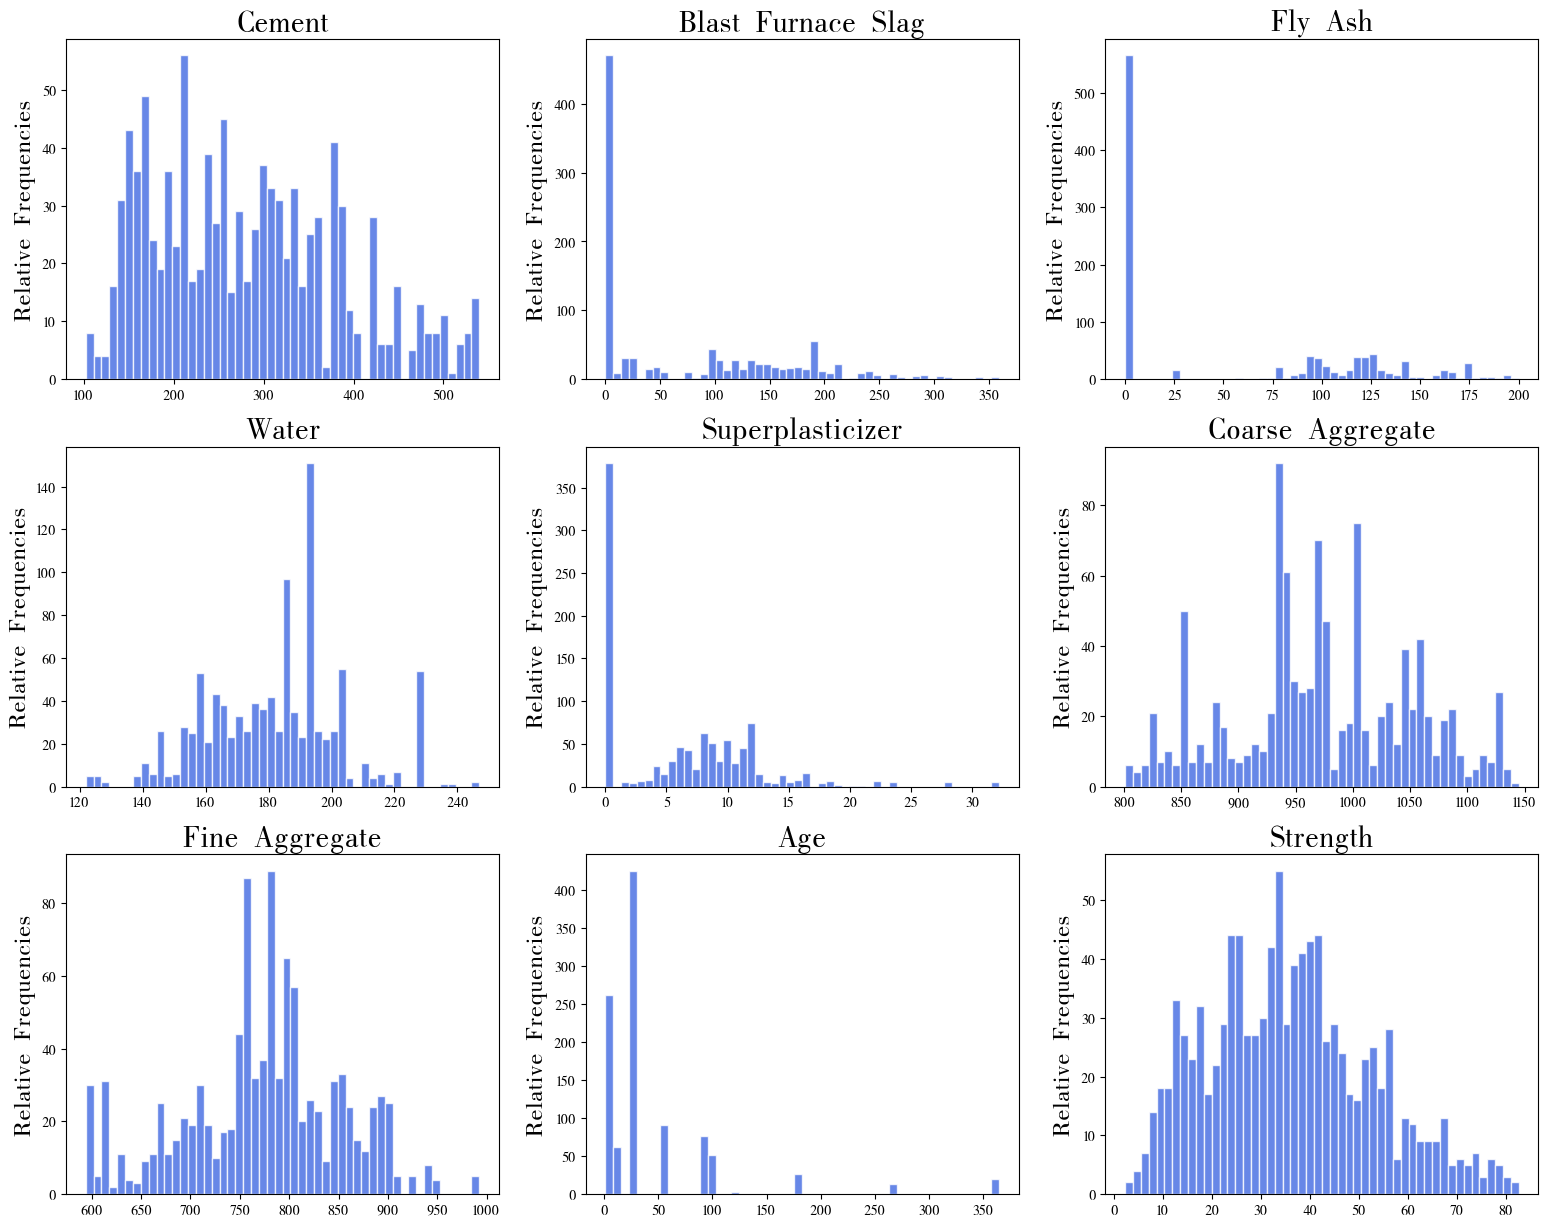

In [10]:
# 绘制各字段的直方图
fig = plt.figure(figsize = (19,15))
plt.subplots_adjust(wspace =0.2, hspace =0.2) # 调整子图间距
ax1 = fig.add_subplot(331) # 定义9个子图
ax2 = fig.add_subplot(332)
ax3 = fig.add_subplot(333)
ax4 = fig.add_subplot(334)
ax5 = fig.add_subplot(335)
ax6 = fig.add_subplot(336)
ax7 = fig.add_subplot(337)
ax8 = fig.add_subplot(338)
ax9 = fig.add_subplot(339)
axCollect = list([ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]) # 创建集合的原因是便于循环绘图，减少重复代码
for i in range(concrete_raw.shape[1]) :
    hist_plotter(axx=axCollect[i],seriesx=concrete_raw.iloc[:,i],
                 bin=50, xlab=None,ylab='Relative Frequencies' , title=concrete_in[i])
plt.savefig(r'histplot.png', dpi=200)

#### 2.2 样本抗压强度正态分布的假设检验

In [11]:
# 观察到Strength字段（目标）有明显的正态分布趋势，因此对其进行假设检验
# H0：样本服从均值、方差为(strength_e, strength_std)的正态分布；采用KS检验的方法对其检验（非参数检验）：
strength_e = concrete_raw['Strength'].mean()
strength_std = concrete_raw['Strength'].std() # 获取均值与方差
res_kstest = stats.kstest(concrete_raw['Strength'], 'norm', (strength_e, strength_std)) # kstest方法，返回一个结果对象
print('均值:',strength_e)
print('标准差:',strength_std)
print(f'ks-test检验样本数据是否符合正态分布，p值为：{res_kstest.pvalue}') # 结果>0.05，因此不拒绝H0，认为其服从正态分布

均值: 35.817961165048544
标准差: 16.705741961912512
ks-test检验样本数据是否符合正态分布，p值为：0.05814694952153987


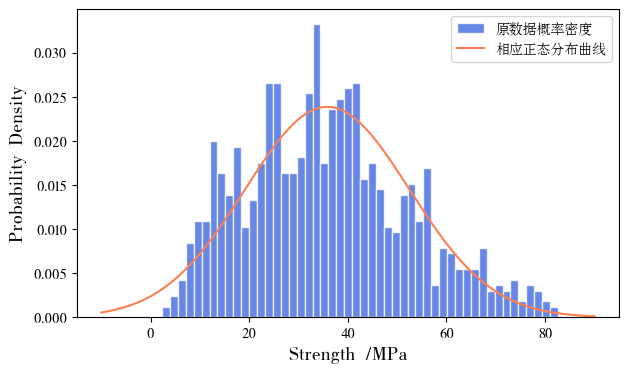

In [12]:
# 给出样本直方图与正态分布曲线，对比
fig = plt.figure(figsize=(7,4))
plt.hist(concrete_raw['Strength'].dropna(), bins = 50, density=True, 
         edgecolor = 'w', alpha = 0.8, color = 'royalblue', label='原数据概率密度') # 绘制Strength分布的直方图，density为归一化选项
xdata_norm = np.linspace(-10,90,180)
ydata_norm = [stats.norm.pdf(i,strength_e,strength_std) for i in xdata_norm] # 构造正态曲线
plt.plot(xdata_norm, ydata_norm, color='coral', label='相应正态分布曲线')
plt.xlabel('Strength /MPa', fontsize=14)
plt.ylabel('Probability Density',fontsize=14) # 绘图修饰
plt.legend()
plt.savefig(r'temp/graph3.svg')
plt.show()

#### 2.3 筛选异常样本并剔除

In [14]:
# 考虑到实际工程中，按非纤维增强的普通配比，很难出现抗压强度80MPa以上的结果
# 此外，强度很低的结果很可能是由于试验、养护方法的错误，因此过高过低的值都视为异常
# 采用2sigma原则进行数据筛选，认为2sigma之外的数值均为异常值
concrete_pro = concrete_raw[(concrete_raw['Strength'] > strength_e-2*strength_std) &
                            (concrete_raw['Strength'] < strength_e+2*strength_std)] # 思路：逐行(逐样本)筛选

In [15]:
# 展示筛选后数据的分布情况
display(concrete_pro.info())
print('----------------------------------------')
display(concrete_pro['Strength'].describe())

<class 'pandas.core.frame.DataFrame'>
Index: 990 entries, 1 to 1029
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Cement              990 non-null    float64
 1   Blast Furnace Slag  990 non-null    float64
 2   Fly Ash             990 non-null    float64
 3   Water               990 non-null    float64
 4   Superplasticizer    990 non-null    float64
 5   Coarse Aggregate    990 non-null    float64
 6   Fine Aggregate      990 non-null    float64
 7   Age                 990 non-null    int64  
 8   Strength            990 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 77.3 KB


None

----------------------------------------


count    990.000000
mean      34.304222
std       15.019052
min        3.320000
25%       23.362500
50%       33.690000
75%       44.280000
max       68.750000
Name: Strength, dtype: float64

In [16]:
# 将筛选剔除后的数据存档，用于此后的机器学习与回归分析
concrete_pro.to_csv(r'Concrete_Data_Pro.CSV',index=0) # index=0，指不保存行索引，否则csv文件左边会多出一列